#This code implements the transformation described on the article: https://ieeexplore.ieee.org/document/6889965

The next code cell reads the data from the given folder

In [27]:
!pip install scikit-plot
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
def worse(X,y):
  f, p = f_classif(X,y)
  return ((-1*f),(-1*p))
X, y = load_breast_cancer(return_X_y=True)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = SelectKBest(score_func=worse,k=10).fit_transform(X, y)
print(X)

[[0.59375282 0.68636364 0.60551811 ... 0.31164518 0.18304244 0.41886396]
 [0.28987993 0.37979798 0.14132266 ... 0.08453875 0.0911101  0.22287813]
 [0.51430893 0.50959596 0.21124684 ... 0.20569032 0.12700551 0.21343303]
 ...
 [0.28816467 0.26767677 0.13732098 ... 0.07454832 0.10354739 0.1519087 ]
 [0.58833619 0.67525253 0.42544229 ... 0.21610289 0.18276605 0.45231536]
 [0.         0.26616162 0.18702612 ... 0.26563291 0.06523361 0.10068215]]


#The next two code cells come from the code of scikit-plot.metrics module
I'm copying and pasting instead of just importing because I need an average KS for the curves as a way to do not a biased solution besides that the generated values are useful for reorganizing the ks

In [0]:
#@title
from sklearn.preprocessing import LabelEncoder
def binary_ks_curve(y_true, y_probas):
    """This function generates the points necessary to calculate the KS
    Statistic curve.
    Args:
        y_true (array-like, shape (n_samples)): True labels of the data.
        y_probas (array-like, shape (n_samples)): Probability predictions of
            the positive class.
    Returns:
        thresholds (numpy.ndarray): An array containing the X-axis values for
            plotting the KS Statistic plot.
        pct1 (numpy.ndarray): An array containing the Y-axis values for one
            curve of the KS Statistic plot.
        pct2 (numpy.ndarray): An array containing the Y-axis values for one
            curve of the KS Statistic plot.
        ks_statistic (float): The KS Statistic, or the maximum vertical
            distance between the two curves.
        max_distance_at (float): The X-axis value at which the maximum vertical
            distance between the two curves is seen.
        classes (np.ndarray, shape (2)): An array containing the labels of the
            two classes making up `y_true`.
    Raises:
        ValueError: If `y_true` is not composed of 2 classes. The KS Statistic
            is only relevant in binary classification.
    """
    y_true, y_probas = np.asarray(y_true), np.asarray(y_probas)
    lb = LabelEncoder()
    encoded_labels = lb.fit_transform(y_true)
    if len(lb.classes_) != 2:
        raise ValueError('Cannot calculate KS statistic for data with '
                         '{} category/ies'.format(len(lb.classes_)))
    idx = encoded_labels == 0
    data1 = np.sort(y_probas[idx])
    data2 = np.sort(y_probas[np.logical_not(idx)])

    ctr1, ctr2 = 0, 0
    thresholds, pct1, pct2 = [], [], []
    while ctr1 < len(data1) or ctr2 < len(data2):

        # Check if data1 has no more elements
        if ctr1 >= len(data1):
            current = data2[ctr2]
            while ctr2 < len(data2) and current == data2[ctr2]:
                ctr2 += 1

        # Check if data2 has no more elements
        elif ctr2 >= len(data2):
            current = data1[ctr1]
            while ctr1 < len(data1) and current == data1[ctr1]:
                ctr1 += 1

        else:
            if data1[ctr1] > data2[ctr2]:
                current = data2[ctr2]
                while ctr2 < len(data2) and current == data2[ctr2]:
                    ctr2 += 1

            elif data1[ctr1] < data2[ctr2]:
                current = data1[ctr1]
                while ctr1 < len(data1) and current == data1[ctr1]:
                    ctr1 += 1

            else:
                current = data2[ctr2]
                while ctr2 < len(data2) and current == data2[ctr2]:
                    ctr2 += 1
                while ctr1 < len(data1) and current == data1[ctr1]:
                    ctr1 += 1

        thresholds.append(current)
        pct1.append(ctr1)
        pct2.append(ctr2)

    thresholds = np.asarray(thresholds)
    pct1 = np.asarray(pct1) / float(len(data1))
    pct2 = np.asarray(pct2) / float(len(data2))

    if thresholds[0] != 0:
        thresholds = np.insert(thresholds, 0, [0.0])
        pct1 = np.insert(pct1, 0, [0.0])
        pct2 = np.insert(pct2, 0, [0.0])
    if thresholds[-1] != 1:
        thresholds = np.append(thresholds, [1.0])
        pct1 = np.append(pct1, [1.0])
        pct2 = np.append(pct2, [1.0])

    differences = pct1 - pct2
    ks_statistic, max_distance_at = (np.max(differences),
                                     thresholds[np.argmax(differences)])

    return thresholds, pct1, pct2, differences, ks_statistic, max_distance_at, lb.classes_

In [0]:
#@title
import matplotlib.pyplot as plt
def plot_ks_statistic(thresholds, pct1, pct2, differences, ks_statistic, \
        max_distance_at, classes, title='KS Statistic Plot',
                      ax=None, figsize=None, title_fontsize="large",
                      text_fontsize="medium"):
    """Generates the KS Statistic plot from labels and scores/probabilities
    Args:
        y_true (array-like, shape (n_samples)):
            Ground truth (correct) target values.
        y_probas (array-like, shape (n_samples, n_classes)):
            Prediction probabilities for each class returned by a classifier.
        title (string, optional): Title of the generated plot. Defaults to
            "KS Statistic Plot".
        ax (:class:`matplotlib.axes.Axes`, optional): The axes upon which to
            plot the learning curve. If None, the plot is drawn on a new set of
            axes.
        figsize (2-tuple, optional): Tuple denoting figure size of the plot
            e.g. (6, 6). Defaults to ``None``.
        title_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "large".
        text_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values. Defaults to
            "medium".
    Returns:
        ax (:class:`matplotlib.axes.Axes`): The axes on which the plot was
            drawn.
    Example:
        >>> import scikitplot as skplt
        >>> lr = LogisticRegression()
        >>> lr = lr.fit(X_train, y_train)
        >>> y_probas = lr.predict_proba(X_test)
        >>> skplt.metrics.plot_ks_statistic(y_test, y_probas)
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe967d64490>
        >>> plt.show()
        .. image:: _static/examples/plot_ks_statistic.png
           :align: center
           :alt: KS Statistic
    """

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    ax.plot(thresholds, pct1, lw=3, label='Class {}'.format(classes[0]))
    ax.plot(thresholds, pct2, lw=3, label='Class {}'.format(classes[1]))
    ax.plot(thresholds,differences, lw=3, label='Differences',color='gray')
    idx = np.where(thresholds == max_distance_at)[0][0]
    ax.axvline(max_distance_at, *sorted([pct1[idx], pct2[idx]]),
               label='KS Statistic: {:.3f} at {:.3f}'.format(ks_statistic,
                                                             max_distance_at),
               linestyle=':', lw=3, color='black')

    ax.set_xlim([0, 1.0])
    ax.set_ylim([np.min(np.min(differences),0), 1.0])

    ax.set_xlabel('Threshold', fontsize=text_fontsize)
    ax.set_ylabel('Percentage below threshold', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='lower right', fontsize=text_fontsize)

    return ax

#my implementation of the algorithm described on the article is on the following code cells

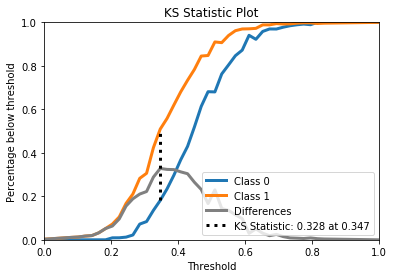

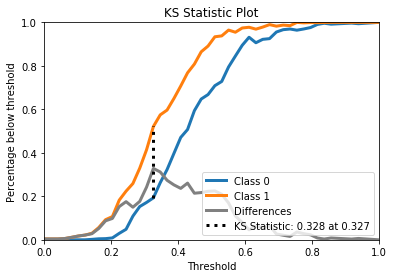

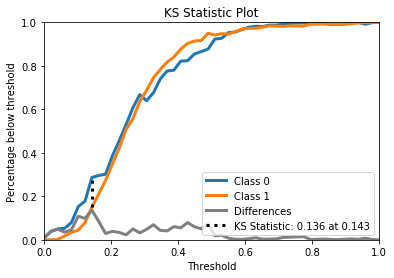

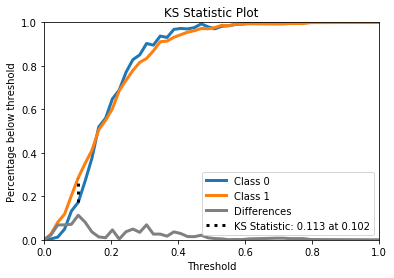

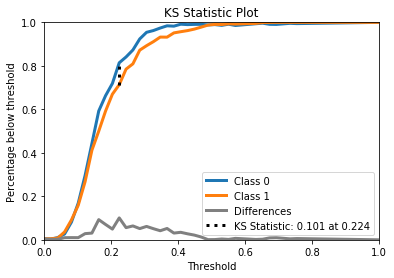

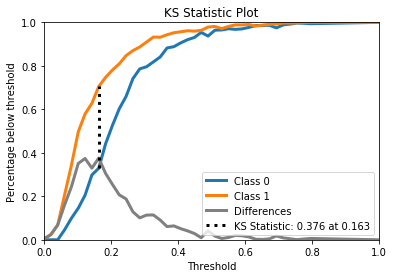

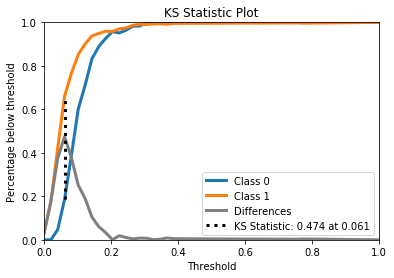

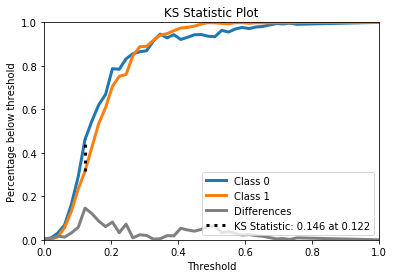

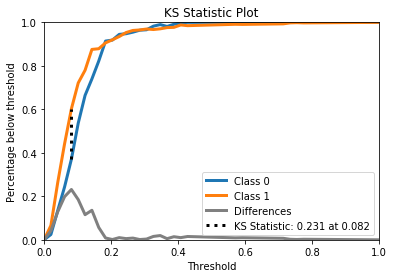

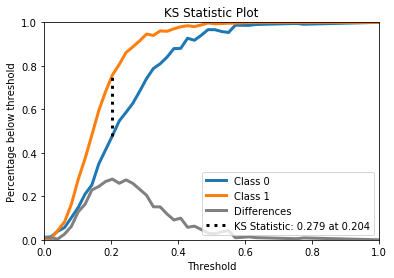

In [28]:
#This code calculates the average (smooth) KS
from statistics import mean
from random import choices
from scipy.interpolate import interp1d
f_diffs = []
th_f = []
n=40#number of bootstraps
for col in np.transpose(X):
    #data normalization
    f=np.array(col);
    #calculate ks
    pct1s = []
    pct2s = []
    diffs = []
    th_b = []
    for i in range(n):
      sample=choices(list(zip(f,y)),k=1200)
      y_true = [s[1] for s in sample]
      y_proba = [s[0] for s in sample]
      results = list(binary_ks_curve(y_true,y_proba))
      th_b.append(results[0])
      pct1s.append(results[1])
      pct2s.append(results[2])
      diffs.append(results[3])
    x=[v for th in th_b for v in th]
    y0,y1=([v for p in pct1s for v in p],[v for p in pct2s for v in p])
    indexes_X = {xi: [i for i,e in enumerate(x) if(e==xi)] for xi in list(set(x)) if(len([i for i,e in enumerate(x) if(e==xi)])>1)}
    for k in indexes_X.keys():
      y0[indexes_X[k][0]]=np.mean([y0[xi] for xi in indexes_X[k]])
      y1[indexes_X[k][0]]=np.mean([y1[xi] for xi in indexes_X[k]])
    indices_to_remove = [indexes_X[k][1:] for k in indexes_X.keys()]
    x=[x[i] for i in range(len(x)) if not(i in indices_to_remove)]
    y0=[y0[i] for i in range(len(y0)) if not(i in indices_to_remove)]
    y1=[y1[i] for i in range(len(y1)) if not(i in indices_to_remove)]
    pct1=interp1d(x,y0,axis=0)
    pct2=interp1d(x,y1,axis=0)
    results[0] = list(np.linspace(0,1))
    results[1], results[2] = (list(pct1(results[0])),list(pct2(results[0])))
    results[3] = [abs(v1-v2) for v1,v2 in zip(results[1],results[2])]
    results[4]=np.max(results[3])
    results[5]=results[0][np.argmax(results[3])]
    th_f.append(results[0])
    f_diffs.append(results[3])
    plot_ks_statistic(*results)

In [0]:
#auxiliary functions
def ecdf(x):
    """ Compute ECDF """
    n = x.size
    y = np.arange(1, n+1) / n
    return y

In [0]:
#my insight: instead of just putting regions of increasing information gain on the left order by the amount of information gain increased
#another insight: if the KS decreases more than increases it's better to start decreasing and than increase because the area will be larger
coefs_ang_f = [[((f_diffs[th_f.index(th)][th.index(th_i)+1]-f_diffs[th_f.index(th)][th.index(th_i)])/(th[th.index(th_i)+1]-th_i)) for th_i in th[:-1]] for th in th_f]
for c in coefs_ang_f:
  c.append(c[-1])
sorted_th_f = [sorted(th,key=lambda th_i: coefs_ang_f[th_f.index(th)][th.index(th_i)]) for th in th_f]
#conferir se chave e valor não estão invertidos na linha de baixo
new_thresholds_f = [interp1d(sorted_th_f[f],th_f[f],axis=0,fill_value=(0,1)) for f in range(len(th_f))]
features_train = [list(col) for col in np.transpose(X)]
cdfs_f = [interp1d(np.sort(f),ecdf(np.sort(f)),axis=0,fill_value=(0,1)) for f in np.transpose(X)]
ppfs_f = [interp1d(ecdf(np.sort(f)),list(np.sort(f)),axis=0,fill_value="extrapolate") for f in X]
new_values_train = []
for i in range(len(features_train)):
  thresholds_train = cdfs_f[i](features_train[i])
  new_thresholds_train = new_thresholds_f[i](thresholds_train)
  new_values_train.append(ppfs_f[i](new_thresholds_train))

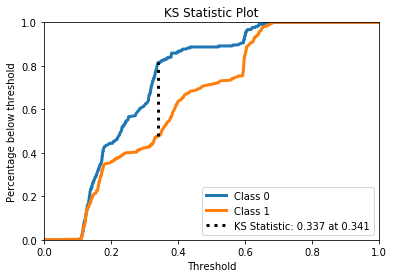

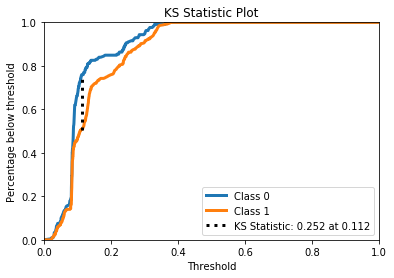

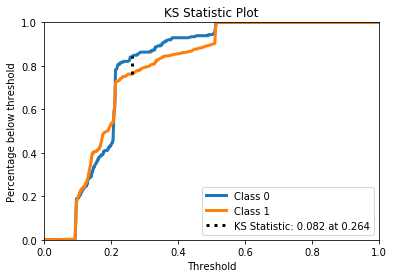

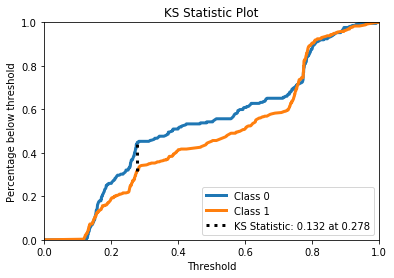

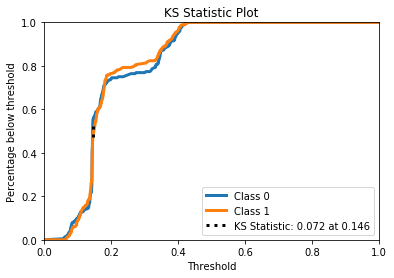

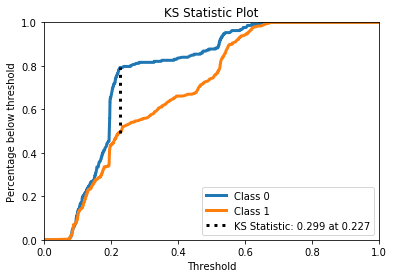

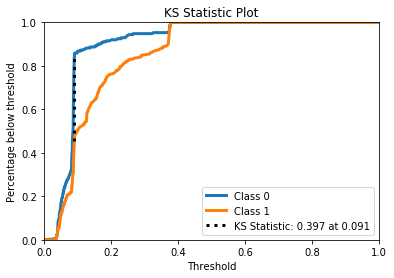

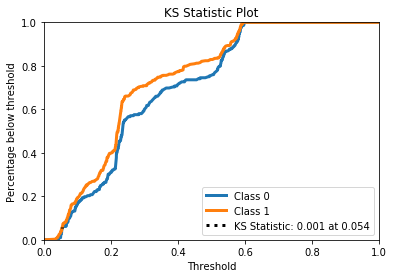

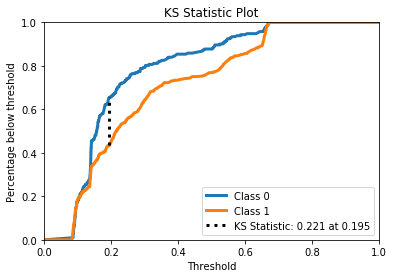

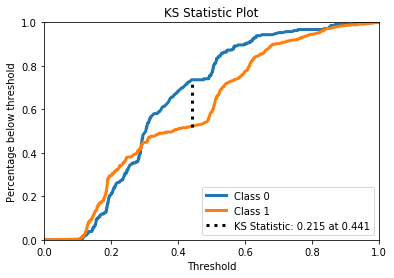

In [46]:
from scikitplot.metrics import plot_ks_statistic as pks
for col in new_values_train:
  f=np.array(col);
  y_proba = list(map(list, zip([1-x for x in f],f)))
  pks(y,y_proba)